In [1]:
from __future__ import division
from pylab import rcParams
import simpy
import random
import statistics
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import pickle
import math

In [2]:
def load_market_data():
    for i in range(2, 20):
        df = pd.DataFrame()
        if(i>9):
            df = df.append(
                pd.read_csv('./data/energy_price/PUB_PriceHOEPPredispOR_20'+str(i)+'.csv', skiprows=3))
        else: 
            df = df.append(
                pd.read_csv('./data/energy_price/PUB_PriceHOEPPredispOR_200'+str(i)+'.csv', skiprows=3))
        df = clean_market_data(df)
    return df

def clean_market_data(df):
    try:
        df['HOEP'] = pd.to_numeric(df['HOEP'].str.replace(',', ''))
    except:
        #print("Already Number")
        ""
    return df

def load_data():
    return pickle.load( open( "./data/ampds.p", "rb" ) )

def weather_data():
    climate = pd.read_csv('./data/load_profile/Climate_HourlyWeather.csv')
    drop = ['Data Quality', 'Temp Flag', 'Dew Point Temp Flag', 'Wind Spd Flag', 'Stn Press Flag',
          'Hmdx Flag', 'Wind Chill Flag', 'Wind Dir Flag', 'Rel Hum Flag', 'Visibility Flag']
    climate = climate.drop(columns = drop, axis=1)
    return climate



In [8]:
ds = load_data()

In [9]:

print(ds['TVE'].describe()['apparent']['count'] )
print(ds['TVE'].astype(bool).sum(axis=0)['apparent'])

1051200.0
1038529


In [3]:
def get_rands_from_data(inputdata, num):

    print(inputdata)
    data = inputdata.fillna(0)
    hist, bins = np.histogram(data, bins=50)

    bin_midpoints = bins[:-1] + np.diff(bins)/2
    cdf = np.cumsum(hist)
    cdf = cdf / cdf[-1]
    values = np.random.rand(num)
    value_bins = np.searchsorted(cdf, values)
    random_from_cdf = bin_midpoints[value_bins]

    plt.subplot(121)
    plt.hist(data, 50)
    plt.subplot(122)
    plt.hist(random_from_cdf, 50)
    plt.show()
    print(random_from_cdf)

0        28.0
1        17.0
2        26.0
3        39.0
4        30.0
         ... 
17515    21.0
17516    14.0
17517     7.0
17518    10.0
17519     4.0
Name: Wind Spd (km/h), Length: 17520, dtype: float64


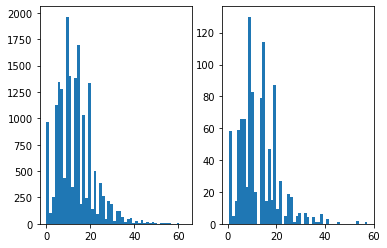

[25.83 20.79  6.93  9.45 19.53 14.49 14.49 10.71  6.93 13.23 15.75  6.93
 17.01 17.01  3.15 19.53 11.97 29.61  8.19 40.95 11.97 19.53 13.23  0.63
  6.93 14.49  5.67 14.49  0.63 25.83  6.93  8.19 14.49 14.49 10.71 17.01
  9.45  5.67  9.45 14.49 14.49 25.83  9.45  8.19  6.93  8.19 10.71 13.23
 13.23 10.71 19.53 23.31  5.67  5.67  6.93 14.49 23.31 17.01  9.45  4.41
 24.57  3.15 15.75  0.63  9.45 14.49  8.19  0.63  9.45 13.23 24.57 22.05
 10.71 17.01  5.67 32.13 24.57  9.45  9.45 10.71 14.49  6.93 14.49 18.27
  5.67  6.93 13.23 38.43  4.41  5.67 13.23 13.23 18.27 13.23 25.83 14.49
 10.71 40.95  5.67  0.63 14.49  9.45  6.93  6.93  6.93  9.45 13.23 32.13
  9.45 14.49 14.49 19.53 17.01 10.71 14.49  5.67 14.49  5.67  6.93 20.79
  0.63 10.71 14.49  9.45 10.71 14.49  3.15  4.41 14.49 19.53  5.67 19.53
  5.67 14.49  9.45 19.53 14.49 29.61  0.63 10.71 22.05 33.39 17.01  4.41
 10.71 10.71 13.23  0.63  9.45  6.93  9.45  9.45 19.53 13.23 13.23  5.67
 13.23  0.63 25.83  0.63 11.97 13.23 19.53  9.45  4

In [34]:
test = weather_data()
get_rands_from_data( test["Wind Spd (km/h)"], 1000)

In [4]:
class Meter(object):

    load_distros = []
    load_infos = []

    #structure of load infos - 
    # - is_controllable
    # - state_connection
    # - time_triggers
    #consumption of power by appliances on time step

    loads = []
    states = []
    durations = []
    state_targets = []

    net_load = 0
    #power_thresh = 200
    
    def __init__(self, json_path):
        params = json.load(open(json_path))

In [8]:
class House(object):
    
    controls = []
    trigger_probs = []
    duration_distros = []
    
    meter = Meter('house_params.json')
    timestep = 0
    
    
    def __init__(self, env, json_path):
        self.env = env
        self.meter.meter = Meter(json_path)


    def update_state(self):
        infos = self.meter.load_infos
        for i in range(0, len(infos)):
            #state connection is in format [effect when on, effect when off], 2 numbers
            #TODO add in state initialization
            if infos[i]['state_connection'][0]>0 and self.controls[i]:
                self.meter.states[i]+=infos[i]['state_connection'][0]
            else :
                self.meter.states[i]+=infos[i]['state_connection'][1]

            if self.meter.durations[i]>0:
                self.meter.durations[i]-=1
                if self.meter.durations[i]==0:
                    self.controls[i]=False

    def update_loads(self):
        load=0 
        infos = self.meter.load_infos
        for i in range(0, len(infos)):
            if self.controls[i]:
                self.meter.loads[i]=get_rands_from_data(self.meter.load_distros[i], 1)[0]

    def time_triggers(self):
        infos = self.meter.load_infos
        for i in range(0, len(infos)):
            if infos[i]['time_triggers'] and self.controls[i] == False:
                self.controls[i] = random.random()<self.meter.load_distros[i]
                self.meter.durations[i] = get_rands_from_data(self.duration_distros[i], 1)[0]


    #critical loads can be treated as 1 in this scenario    
    def get_critical_load(self):
        infos = self.meter.load_infos
        crit_load = 0
        for i in range(0, len(infos)):
            if infos[i]['is_controllable'] == False:
                crit_load+=self.meter.loads[i]
        return crit_load
    
    def get_control_loads(self):
        infos = self.meter.load_infos
        load = 0
        for i in range(0, len(infos)):
            if infos[i]['is_controllable']:
                load+=self.meter.loads[i]

        return load

    
    #important to call these 3 at least once before running simulation
    def set_load_distros(self, distros):
        self.meter.load_distros = distros

    def set_dur_distros(self, distros):
        self.duration_distros = distros

    def set_trigger_probs(self, probs):
        self.trigger_probs = probs

    #performs all functions for a typical iteration
    def run_load(self, timestep):
        #print("Next")
        self.meter.net_load = 0
        self.time_triggers()
        self.update_loads()
        self.meter.net_load+=self.get_critical_load()
        self.meter.net_load+=self.get_control_loads()
        #print(self.meter.load_distros)
        self.update_state()
        #print("LOAD IS"+str(self.meter.net_load))
        return self.meter.net_load


    


In [9]:
total_load =  0
timestep = 0
ren_power = 0
#replace with probabilistic model sampling
total_cost = 0

def run_grid_loads(env, loads):

    global total_load
    global timestep
    total_load= 0
    
    for l in loads:
        total_load+=l.run_load(timestep)
        #print(total_load)
    
    return total_load


def run_simulation(env, num_houses, renewable_sources, num_batteries):
    global timestep
    houses = []
    dataset = load_data()
    infos = init_info(dataset, True)
    distrs = get_distrs_from_ds(dataset)
    for i in range(0, num_houses):
        h = House(env, 'house_params.json')
        h.set_load_distros(distrs)
        h.meter.infos = infos
        houses.append(h)

    while True:
        yield env.timeout(1)  # Wait a bit before generating a new person
        timestep += 1
        if timestep%60==0:
            update_price()
            update_weather()
        print(run_grid_loads(env, houses))
        #print(get_power(renewable_sources))

#TODO add some sophistication so that it's time-based
def get_distrs_from_ds(ds):
    distrs = []
    for key in ds.keys():
        if "INFO" not in key:
            distrs.append(ds[key]['apparent'])
    #print(distrs)
    return distrs

# - is_controllable
    # - state_connection
    # - time_triggers
#add sophistication for the special keys
def init_info(ds ,isDefault):
    infos = []
        
    for key in ds.keys():
        if "INFO" in key:
            tmp = ds[key]
            if isDefault:
                tmp['is_controllable']= False
                tmp['time_triggers'] = False
                tmp['state_connection'] = [0.01, -0.1]
            infos.append(tmp)
    return infos


def get_power(rens):
    global ren_power
    global total_cost
    ren_power = 0
    #would likely get renewables probabilistic cost at this time
    for i in range(0, rens):
        ren_power+=random.randint(220, 290)
    
    if total_load<=ren_power:
        total_cost -= (ren_power-total_load)*energy_price
    else:
        total_cost -= (ren_power-total_load)*energy_price
    
    return total_cost

market_params = {}
weather_params = {}

weather_predictions = []
market_predictions = []
weather_pred_depth = 10
market_pred_depth = 24

#TODO add in some noise to the prediction "models"
def update_weather():
    global timestep
    global weather_params
    global weather_predictions
    weather = weather_data()
    weather_params = weather.iloc[math.floor(timestep/60)]

    weather_predictions = weather.iloc[math.floor(timestep/60):math.floor(timestep/60)+weather_pred_depth]
    #print(weather_params)
    
#performed every hour
def update_price():
    global timestep
    global market_params
    global energy_price
    global market_predictions
    market = load_market_data()
    market_params = market.iloc[math.floor(timestep/60)]
    energy_price = market_params['HOEP']
    market_predictions = market.iloc[math.floor(timestep/60):math.floor(timestep/60)+market_pred_depth]
    #print(market_params)

def main():
    # Setup
    random.seed(42)

    # Run the simulation
    env = simpy.Environment()
    env.process(run_simulation(env, 10, 4, 1))
    #Seconds to run the simulation
    env.run(until=1440)


if __name__ == '__main__':
    main()

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [45]:
#Measurements / Observations
# 
'''
1 week of simulation with 10 loads takes roughly 22-23 seconds on my computer
1 day with 10 loads takes roughly 3 seconds

With the current buy / sell model (no battery) the price either skews to the left 
or the right, so it's a bit tougher to make highly consistent

AC stays almost consistently on to maintain exact temperature, but if pushed to degree
or a smaller precision power / ac time can be saved significantly

Load modelling seems to be relatively functional. Controls will be maintained for only 
sections of the load modelling, such as AC, Heat Pump, and Fridge
    - based on the AMPdS dataset these are actually a substantial portion of the load
    
Tweaking seemingly does a lot to save on loads

''' 

"\n1 week of simulation with 10 loads takes roughly 22-23 seconds on my computer\n1 day with 10 loads takes roughly 3 seconds\n\nWith the current buy / sell model (no battery) the price either skews to the left \nor the right, so it's a bit tougher to make highly consistent\n\nAC stays almost consistently on to maintain exact temperature, but if pushed to degree\nor a smaller precision power / ac time can be saved significantly\n\nLoad modelling seems to be relatively functional. Controls will be maintained for only \nsections of the load modelling, such as AC, Heat Pump, and Fridge\n    - based on the AMPdS dataset these are actually a substantial portion of the load\n    \nTweaking seemingly does a lot to save on loads\n\n"

In [6]:
update_weather()

NameError: name 'update_weather' is not defined